# A/B Case Study

So this is a generic A/B style data analysis from an online dataset. The story behind this dataset is that a company wants to attempt to compare a few things about purchases made by its customers. 

Firstly, a $10 bonus has been added to the referral program between the two months in this dataset (Oct/Nov). We'd like to see if its resulted in any increase in the number of referrals. 

Secondly, we have the purchase value made by each user within a set of countries. We'd like to see what information we can use to compare these countries. 

Lets see if we can help figure out the details!

In [28]:
#import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import bartlett
from scipy.stats import f_oneway
from scipy.stats import tukey_hsd
from scikit_posthocs import posthoc_ttest

In [2]:
#import the csv
df = pd.read_csv('referral.csv')

In [3]:
#Inspect the data
print(df.head())
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
print(df.info())
print(df.describe())

   user_id        date country  money_spent  is_referral      device_id
0        2  2015-10-03      FR           65            0  EVDCJTZMVMJDG
1        3  2015-10-03      CA           54            0  WUBZFTVKXGQQX
2        6  2015-10-03      FR           35            0  CBAPCJRTFNUJG
3        7  2015-10-03      UK           73            0  PRGXJZAJKMXRH
4        7  2015-10-03      MX           35            0  PRGXJZAJKMXRH
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97341 entries, 0 to 97340
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      97341 non-null  int64         
 1   date         97341 non-null  datetime64[ns]
 2   country      97341 non-null  object        
 3   money_spent  97341 non-null  int64         
 4   is_referral  97341 non-null  int64         
 5   device_id    97341 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 4.5+ MB

In [4]:
# We are going to ignore the user_id and device_id columns since we aren't trying to make any conlusions about them. 
# Since we are after the propotion of new users that are referrals lets look at the counts.
print(f'Years in dataset: {df["date"].dt.year.unique()}')
print(f'Months in dataset: {df["date"].dt.month.unique()}')

# Since October 31st is the start date of the referral program we just need to add it to the november list, 
# can just make its day "28".
df.loc[df['date'] == "2015-10-31", 'date'] = "2015-11-28"


for month in df['date'].dt.month.unique():
    month_count = df[df['date'].dt.month == month].shape[0]#since we have no NANs
    referral_sum = df[df['date'].dt.month == month]['is_referral'].sum()
    print(f'Month: {month}, referred: {referral_sum}, Total: {month_count}, portion referred: {referral_sum/month_count}')  

Years in dataset: [2015]
Months in dataset: [10 11]
Month: 10, referred: 0, Total: 47341, portion referred: 0.0
Month: 11, referred: 28017, Total: 50000, portion referred: 0.56034


So at this point its quite obvious that the referral program had an effect, since there was no referrals before its introduction. That being said, we are only looking at a sample size of 1 month each, which likely isn't representative of the population. 

While we can't really draw conclusions about the referrals before the program, we can break the referrals down by day post implementation. From here we could see if any trends follow.

In [5]:
# Group the df by day, and sum the number of referrals
grouped_df = df[['date', 'is_referral']].groupby(['date']).sum()
grouped_df['Total'] = df[['date', 'is_referral']].groupby(['date']).count()
grouped_df['Proportion referred'] = grouped_df['is_referral']/grouped_df['Total']

#Lets drop October
grouped_df = grouped_df.loc['2015-11']
grouped_df.head(15)

,is_referral,Total,Proportion referred
date,,,
2015-11-01,1749,3162,0.553131
2015-11-02,697,1218,0.572250
2015-11-03,700,1273,0.549882
2015-11-04,660,1180,0.559322
2015-11-05,660,1201,0.549542
2015-11-06,719,1236,0.581715
2015-11-07,1788,3134,0.570517
2015-11-08,1747,3164,0.552149
2015-11-09,682,1194,0.571189


Printing the first 15 days it becomes obvious two of the seven days in the week have a higher referral rate (one would presume the weekends). One thing we could try and run is a two proportion Z-test between weekends and days to see if they have different proportion of referrals. However, the sample size for weekends is five. Doing a quick power analysis (90%) for sample size from a site (https://select-statistics.co.uk/calculators/sample-size-calculator-two-proportions/) detecting even a 10% difference (larger than what we have) in referral proportions between weekends and weekdays would require a sample size of roughly 385. So thats not a valid test in our scenario. We've reached the extent of any conclusions we can draw from the referral program. 

The next avenue we can explore is whether or not customers spend a different amount of money depending on what country they are in.  

         Purchases (n)  Mean Purchase Value ($)  Purchase Variance
country                                                           
CA                9440                45.526271         617.455184
CH                1229                58.328723         866.658954
DE               11093                45.107726         606.576115
ES                9831                43.602685         360.837649
FR               15396                43.684528         365.521062
IT               11446                43.653678         370.957028
MX                8133                41.343047         493.121360
UK               15493                45.922610         618.956120
US               15280                45.808770         622.768848


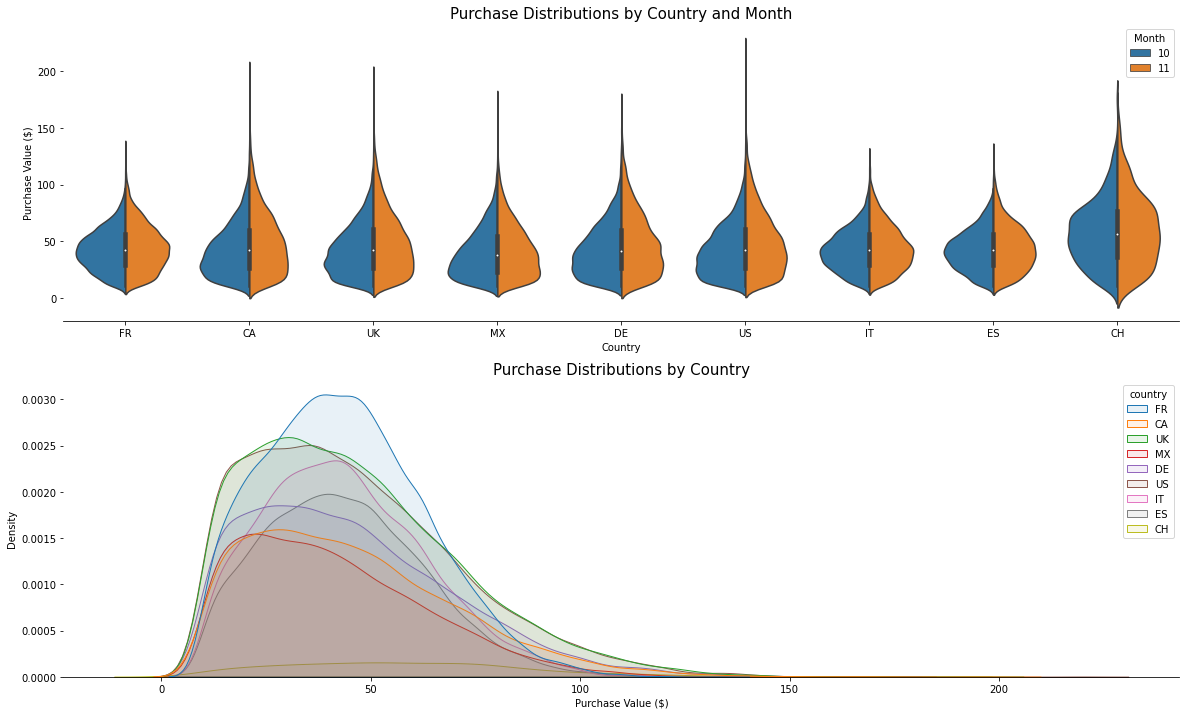

In [54]:
#We've got 9 countries to work with here. Lets calculate their grouped properties. 
count_df = df[['money_spent', 'country']].groupby(['country']).count()
mean_df = df[['money_spent', 'country']].groupby(['country']).mean()
VAR_df = df[['money_spent', 'country']].groupby(['country']).var()

# Merge it all into one dataframe with country as index
country_df = pd.merge(count_df, mean_df, how='inner', on='country')
country_df = pd.merge(country_df, VAR_df, how='inner', on='country')
country_df.rename(columns = {'money_spent_x':'Purchases (n)', 'money_spent_y':'Mean Purchase Value ($)', 'money_spent':'Purchase Variance'}, inplace = True)
print(country_df)

# Lets plot the distribution of each country
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

# First plot the distributions on a violin plot to see if there is any visible difference between the two months we should consider
sns.violinplot(ax = ax1, x='country', y='money_spent', hue=df['date'].dt.month, split=True, data=df)
ax1.set_title('Purchase Distributions by Country and Month', fontsize = 15)
ax1.set(xlabel='Country', ylabel='Purchase Value ($)')
ax1.legend(title='Month')

# Next lets just plot the KDE of each country
sns.kdeplot(ax = ax2, data = df, x = 'money_spent', hue = 'country', alpha = 0.1, fill = True)
ax2.set_title('Purchase Distributions by Country',fontsize = 15)
ax2.set(xlabel='Purchase Value ($)', ylabel='Density')


sns.despine(left=True)
plt.show()

First off, the distributions shown in the top plot don't look to differ by month which makes things less complicated for us.
The distribution in purchase value (bottom plot) for each country looks roughly normally distributed (slightly skewed), but the variances in the summary table look quite different. Unsurprisingly our lowest sample size country "CH" has the largest variance.

We can confirm normality with a Shaprio-Wilk test, and homogeneity in variance using Bartlett's test. 
An alternative option for normality is the Anderson-Darling, but has almost equivalent performance. Similarly for variance we could also use Levene's test, but because these distributions look normal Bartlett's would likely be superior. 

In [7]:
for country in df['country'].unique():
    print(f'{country}, {shapiro(df[df["country"] == country]["money_spent"])}')
    
# Separating each country for easy use from now on.
FR = df[df["country"] == 'FR']["money_spent"]
CA = df[df["country"] == 'CA']["money_spent"]
UK = df[df["country"] == 'UK']["money_spent"]
MX = df[df["country"] == 'MX']["money_spent"]
DE = df[df["country"] == 'DE']["money_spent"]
US = df[df["country"] == 'US']["money_spent"]
IT = df[df["country"] == 'IT']["money_spent"]
ES = df[df["country"] == 'ES']["money_spent"]
CH = df[df["country"] == 'CH']["money_spent"]
print('\n')
print(bartlett(FR, CA, UK, MX, DE, US, IT, ES, CH))

FR, ShapiroResult(statistic=0.9807144999504089, pvalue=5.874103032603201e-41)
CA, ShapiroResult(statistic=0.9438521265983582, pvalue=0.0)
UK, ShapiroResult(statistic=0.9473286271095276, pvalue=0.0)
MX, ShapiroResult(statistic=0.9449476003646851, pvalue=0.0)
DE, ShapiroResult(statistic=0.9461669921875, pvalue=0.0)
US, ShapiroResult(statistic=0.947159469127655, pvalue=0.0)
IT, ShapiroResult(statistic=0.9774793982505798, pvalue=6.782758206213056e-39)
ES, ShapiroResult(statistic=0.980200469493866, pvalue=8.922217936157133e-35)
CH, ShapiroResult(statistic=0.9726873636245728, pvalue=1.771446081185249e-14)


BartlettResult(statistic=3019.547054054759, pvalue=0.0)


C:\Users\Ralph\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Our Shapiro-Wilk demonstrates good normality for each country's distribution. Its important to note though that Scipy warns about the accuracy of the p-value above 5000 samples. In our case we can focus on the test statistic, which is basically the ratio in variances between our distributions and an equivalent normal distribution. Since the test statistic is close to one for each country we can safely assume normality. 

Our Bartlett test on the other hand has told us that our countries are heteroscedastic (p~0). This means we can't really use a one-way ANOVA to prove the countries are similar. However, we can still use an ANOVA to prove that atleast one country is different from the rest since heteroscedasticity would generally lower power (the probability of correctly rejecting the null-hypothesis of equvalent means). 

In [8]:
#One-way ANOVA of countries. 
f_oneway(FR, CA, UK, MX, DE, US, IT, ES, CH)

F_onewayResult(statistic=99.5548146853144, pvalue=5.94620998205075e-166)

So since we got a significant value from our ANOVA we can firmly trust that not all countries have a similar mean purchase value. The next thing we can do is narrow down which countries are different with some post-hoc testing. However, this is a little trickier due to our countries being unbalanced in sample count and heteroscedastic. 

We can start with a Tukey's HSD which is basically a t-test that corrects for family wise error rates. 
As a backup to put any doubts to rest on the comparisons rising from heteroscedasticity we should also perform Welch's t-test (accounting for unbalanced datasets) with something like a Holm - Bonferroni adjustment for multiple comparisons. This approach is a bit more powerful and should give us food for thought if the traditional Tukey's comparison p-values are approaching rejection territory.

In [59]:
# Tukey-Kramer Method
print("0 = FR, 1 = CA, 2 = UK, 3 = MX, 4 = DE, 5 = US, 6 = IT, 7 = ES, 8 = CH")
tukey = tukey_hsd(FR, CA, UK, MX, DE, US, IT, ES, CH)
print(tukey)


# Welch's t-test with Bonferroni adjustment
countries = [FR, CA, UK, MX, DE, US, IT, ES, CH]
print("Welch's t-test with Adjustment, p-value matrix")
posthoc = posthoc_ttest(countries, p_adjust = 'holm')
posthoc_df = pd.DataFrame(data = posthoc)
posthoc_df.rename(columns={1:'FR', 2:'CA', 3:'UK', 4:'MX', 5:'DE', 6:'US', 7:'IT', 8:'ES', 9:'CH'}, inplace=True)
posthoc_df.rename(index={1:'FR', 2:'CA', 3:'UK', 4:'MX', 5:'DE', 6:'US', 7:'IT', 8:'ES', 9:'CH'}, inplace=True)
posthoc_df

0 = FR, 1 = CA, 2 = UK, 3 = MX, 4 = DE, 5 = US, 6 = IT, 7 = ES, 8 = CH
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -1.842     0.000    -2.762    -0.921
 (0 - 2)     -2.238     0.000    -3.039    -1.437
 (0 - 3)      2.341     0.000     1.376     3.307
 (0 - 4)     -1.423     0.000    -2.300    -0.546
 (0 - 5)     -2.124     0.000    -2.928    -1.320
 (0 - 6)      0.031     1.000    -0.838     0.900
 (0 - 7)      0.082     1.000    -0.827     0.991
 (0 - 8)    -14.644     0.000   -16.731   -12.557
 (1 - 0)      1.842     0.000     0.921     2.762
 (1 - 2)     -0.396     0.920    -1.316     0.523
 (1 - 3)      4.183     0.000     3.118     5.248
 (1 - 4)      0.419     0.927    -0.567     1.405
 (1 - 5)     -0.282     0.990    -1.204     0.639
 (1 - 6)      1.873     0.000     0.894     2.852
 (1 - 7)      1.924     0.000     0.909     2.938
 (1 - 8)    -12.802     0.000   -14.938   -10.667
 (2 - 0)   

,FR,CA,UK,MX,DE,US,IT,ES,CH
FR,1.000000e+00,8.235509e-10,2.003047e-17,7.736388e-16,1.470212e-06,1.292744e-15,1.000000e+00,1.000000e+00,5.660178e-130
CA,8.235509e-10,1.000000e+00,1.000000e+00,5.150518e-30,1.000000e+00,1.000000e+00,1.232647e-08,1.896632e-08,1.026720e-59
UK,2.003047e-17,1.000000e+00,1.000000e+00,1.525228e-42,7.366295e-02,1.000000e+00,9.952574e-15,5.831991e-14,8.287949e-60
MX,7.736388e-16,5.150518e-30,1.525228e-42,1.000000e+00,3.056120e-26,3.718773e-40,1.710971e-13,3.318225e-12,1.875583e-120
DE,1.470212e-06,1.000000e+00,7.366295e-02,3.056120e-26,1.000000e+00,1.884018e-01,8.403112e-06,9.512309e-06,3.826887e-66
US,1.292744e-15,1.000000e+00,1.000000e+00,3.718773e-40,1.884018e-01,1.000000e+00,2.899422e-13,1.295754e-12,1.843743e-60
IT,1.000000e+00,1.232647e-08,9.952574e-15,1.710971e-13,8.403112e-06,2.899422e-13,1.000000e+00,1.000000e+00,8.190887e-122
ES,1.000000e+00,1.896632e-08,5.831991e-14,3.318225e-12,9.512309e-06,1.295754e-12,1.000000e+00,1.000000e+00,5.895157e-121
CH,5.660178e-130,1.026720e-59,8.287949e-60,1.875583e-120,3.826887e-66,1.843743e-60,8.190887e-122,5.895157e-121,1.000000e+00


From the Tukey's comparisons we can make some pretty quantitative statements about the differences between countries. 
Some things of interest:

- The Country CH likely has the highest mean purchase value among customers as it has the highest average, and all comparisons have a p-value ~ 0. While likely, we would want to use a one-sided test to say definitively. 
- The Country MX likely has the lowest mean purchase value among customers as it has the lowest average, and all comparisons have a p-value ~ 0. While likely, we would want to use a one-sided test to say definitively.
- [IT, ES, FR] and [US, CA, DE, UK] are two major clusters of countries that are not significantly different within each grouping.

We also notice that the adjusted Welch's t-test didn't have any differing conclusions from the Tukey-Kramer method. However, from the higher power we can see we were a bit closer to rejecting the null hypothesis that DE and UK are not significantly different.

Depending on the situation we could nail down some more specific questions, but this is a good start to a typical A/B study approach. Hope you enjoyed!